In [1]:
import requests
import pandas as pd

In [5]:
server_name = 'http://194.4.103.244:3030'
service_name = 'ds'
request_url = server_name + '/' + service_name

## Getting familiar with the data

In [132]:
query = '''
PREFIX a: <http://www.semanticweb.org/alicia/ontologies/2020/8/singleCellRepositories#> 
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
SELECT
    ?projectTitle
    ?repository
    ?projectSpecimens
    ?cellType
    (COUNT(*) AS ?numSpecimens)
    (SUM(?numCells) AS ?numTotalCells)
WHERE
{
    ?specimenID rdf:type a:Specimen ;
                a:SPR.hasSpecie a:HomoSapiens ;
                a:SPR.hasMinAge ?minAge ;
                a:SPR.hasOrganismPart a:Blood ;
                a:SPR.hasProjectTitle ?projectTitle ;
                a:SPR.isPartOfRepository ?repository ;
                a:SPR.hasTotalCellCount ?numCells ;
                a:SPR.hasCellType ?cellType .
    ?projectID rdf:type a:Project ;
               a:SPR.hasProjectTitle ?projectTitle ;
               a:PR.hasSpecimenCount ?projectSpecimens
    FILTER (?numCells != -1) .
    FILTER (?minAge > 17) .
}
GROUP BY ?projectTitle ?repository ?projectSpecimens ?cellType
ORDER BY ?numTotalCells
'''

In [133]:
response = requests.post(request_url,
       data={'query': query})

# print(response.text)

headers = response.json()["head"]["vars"]
results = response.json()["results"]

rows = []

for result in response.json()["results"]["bindings"]:
    result_dict = {}
    for header in headers:
        result_dict[header] = result[header]['value']
        
    rows.append(result_dict)

df = pd.DataFrame(rows)

df

,projectTitle,repository,projectSpecimens,numCellTypes,numSpecimens,numTotalCells
0,Transcriptomic profiling of antigen-specific T...,SingleCellExpresionAtlas,2,1,2,72
1,Single-cell RNAseq of Human T lymphocyte deriv...,SingleCellExpresionAtlas,2,1,2,119
2,Single cell RNA seq of influenza tetramer spec...,SingleCellExpresionAtlas,1,1,1,210
3,Single cell RNA-sequencing of PBMC derived B c...,SingleCellExpresionAtlas,1,4,4,468
4,Precursors of human CD4+ cytotoxic T lymphocyt...,HumanCellAtlas,28,2,28,2244
5,Immune landscape of viral- and carcinogen-deri...,SingleCellExpresionAtlas,63,1,32,61675
6,A single-cell atlas of the peripheral immune r...,SingleCellExpresionAtlas,12,1,12,92783


## Common metadata between projects

In [10]:
query = '''
PREFIX a: <http://www.semanticweb.org/alicia/ontologies/2020/8/singleCellRepositories#> 
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
SELECT
    ?projectID
    ?projectTitle
    ?repository
    (COUNT(*) AS ?numSpecimens)
    (SUM(?numCells) AS ?numTotalCells)
    ?relation
WHERE
{
    ?specimenID rdf:type a:Specimen ;
                a:SPR.hasSpecie a:HomoSapiens ;
                a:SPR.hasMinAge ?minAge ;
                a:SPR.hasOrganismPart a:Blood ;
                a:SPR.hasProjectTitle ?projectTitle ;
                a:SPR.isPartOfRepository ?repository ;
                a:SPR.hasTotalCellCount ?numCells ;
                ?relation ?value .
    ?project rdf:type a:Project ;
             a:SPR.hasProjectTitle ?projectTitle ;
             a:PR.hasProjectID ?projectID .
    FILTER (?numCells != -1) .
    FILTER (?minAge > 17) .
}
GROUP BY ?projectID ?projectTitle ?repository ?relation
'''

In [11]:
response = requests.post(request_url,
       data={'query': query})

# print(response.text)

headers = response.json()["head"]["vars"]
results = response.json()["results"]

rows = []

for result in response.json()["results"]["bindings"]:
    result_dict = {}
    for header in headers:
        result_dict[header] = result[header]['value']
        
    rows.append(result_dict)

df = pd.DataFrame(rows)

In [12]:
df["numTotalCells"] = pd.to_numeric(df["numTotalCells"])
df['relation'] = df['relation'].apply(lambda x: x.split('#')[1])
df = df.sort_values(by=['projectTitle'], ascending=False)
df

,projectID,projectTitle,repository,numSpecimens,numTotalCells,relation
66,E-MTAB-4850,Transcriptomic profiling of antigen-specific T...,SingleCellExpresionAtlas,2,72,SPR.hasOrganismPart
61,E-MTAB-4850,Transcriptomic profiling of antigen-specific T...,SingleCellExpresionAtlas,2,72,SPR.hasTotalCellCount
117,E-MTAB-4850,Transcriptomic profiling of antigen-specific T...,SingleCellExpresionAtlas,2,72,SPR.isPartOfRepository
46,E-MTAB-4850,Transcriptomic profiling of antigen-specific T...,SingleCellExpresionAtlas,2,72,SPR.hasMaxAge
114,E-MTAB-4850,Transcriptomic profiling of antigen-specific T...,SingleCellExpresionAtlas,2,72,SPR.hasSpecie
...,...,...,...,...,...,...
38,E-GEOD-150728,A single-cell atlas of the peripheral immune r...,SingleCellExpresionAtlas,12,92783,SPR.isPartOfCollection
34,E-GEOD-150728,A single-cell atlas of the peripheral immune r...,SingleCellExpresionAtlas,12,92783,type
17,E-GEOD-150728,A single-cell atlas of the peripheral immune r...,SingleCellExpresionAtlas,12,92783,SPR.hasCellType
6,E-GEOD-150728,A single-cell atlas of the peripheral immune r...,SingleCellExpresionAtlas,12,92783,SPR.hasMinAge


In [13]:
all_columns = set()
for project_title in df['projectTitle'].unique():
    project_columns = df[df['projectTitle'] == project_title]['relation']
    all_columns.update(list(project_columns))

all_columns.remove('type')

print(all_columns)

{'SPR.hasLaboratory', 'SPR.hasMaxAge', 'SPR.hasInstrument', 'SPR.hasSampleType', 'SPR.hasMinAge', 'SPR.isPartOfCollection', 'SPR.hasProjectShortName', 'SPR.hasLibrary', 'SPR.hasOrganismPart', 'SPR.isPartOfRepository', 'SPR.hasTotalCellCount', 'SPR.hasBiopsySite', 'SPR.hasSpecie', 'SPR.hasDisease', 'SPR.isPairedEnd', 'SPR.hasCellType', 'SPR.hasPreservation', 'SPR.hasAgeUnit', 'SPR.hasTotalSizeOfFilesInMB', 'SPR.hasProjectTitle', 'SPR.hasSex', 'SR.hasSpecimenID'}


In [14]:
df_relations = pd.DataFrame(columns= ['project_title'] + list(all_columns))

for project_title in df['projectTitle'].unique():
    project_columns = df[df['projectTitle'] == project_title]['relation']
    row = dict(zip(['project_title'] + list(all_columns) , [project_title] + [False] * len(all_columns)))
    for project_column in project_columns:
        row[project_column] = True
        
    df_relations = df_relations.append(row, ignore_index=True)
df_relations = df_relations.drop(['type'], axis=1)
df_relations

,project_title,SPR.hasLaboratory,SPR.hasMaxAge,SPR.hasInstrument,SPR.hasSampleType,SPR.hasMinAge,SPR.isPartOfCollection,SPR.hasProjectShortName,SPR.hasLibrary,SPR.hasOrganismPart,...,SPR.hasSpecie,SPR.hasDisease,SPR.isPairedEnd,SPR.hasCellType,SPR.hasPreservation,SPR.hasAgeUnit,SPR.hasTotalSizeOfFilesInMB,SPR.hasProjectTitle,SPR.hasSex,SR.hasSpecimenID
0,Transcriptomic profiling of antigen-specific T...,False,True,False,True,True,False,False,False,True,...,True,True,False,True,False,True,True,True,True,False
1,Single-cell RNAseq of Human T lymphocyte deriv...,False,True,False,True,True,False,False,False,True,...,True,True,False,True,False,True,True,True,True,True
2,Single cell RNA-sequencing of PBMC derived B c...,False,True,False,True,True,False,False,False,True,...,True,True,False,True,False,True,True,True,True,True
3,Single cell RNA seq of influenza tetramer spec...,False,True,False,True,True,False,False,False,True,...,True,False,False,True,False,True,True,True,True,True
4,RNA-seq of RBC depleted whole blood from COVID...,False,True,False,True,True,True,False,False,True,...,True,True,False,False,False,True,True,True,True,True
5,Precursors of human CD4+ cytotoxic T lymphocyt...,True,True,True,True,True,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
6,Immune landscape of viral- and carcinogen-deri...,False,True,False,True,True,False,False,False,True,...,True,True,False,True,False,True,True,True,True,True
7,A single-cell atlas of the peripheral immune r...,False,True,False,True,True,True,False,False,True,...,True,True,False,True,True,True,True,True,True,True


In [15]:
df_relations.all()

project_title                   True
SPR.hasLaboratory              False
SPR.hasMaxAge                   True
SPR.hasInstrument              False
SPR.hasSampleType               True
SPR.hasMinAge                   True
SPR.isPartOfCollection         False
SPR.hasProjectShortName        False
SPR.hasLibrary                 False
SPR.hasOrganismPart             True
SPR.isPartOfRepository          True
SPR.hasTotalCellCount           True
SPR.hasBiopsySite              False
SPR.hasSpecie                   True
SPR.hasDisease                 False
SPR.isPairedEnd                False
SPR.hasCellType                False
SPR.hasPreservation            False
SPR.hasAgeUnit                  True
SPR.hasTotalSizeOfFilesInMB     True
SPR.hasProjectTitle             True
SPR.hasSex                      True
SR.hasSpecimenID               False
dtype: bool

In [16]:
intersect_columns = set()
for project_title in df['projectTitle'].unique():
    project_columns = df[df['projectTitle'] == project_title]['relation']
    
    if not intersect_columns:
        intersect_columns = set(project_columns)
        continue
    
    intersect_columns = intersect_columns.intersection(set(project_columns))
    
intersect_columns.remove('type')
    
print(intersect_columns)

{'SPR.hasOrganismPart', 'SPR.hasMaxAge', 'SPR.hasTotalSizeOfFilesInMB', 'SPR.isPartOfRepository', 'SPR.hasSampleType', 'SPR.hasProjectTitle', 'SPR.hasSex', 'SPR.hasTotalCellCount', 'SPR.hasMinAge', 'SPR.hasSpecie', 'SPR.hasAgeUnit'}


## Download the data from the projects

In [17]:
def get_data(project):
    query = '''
        PREFIX a: <http://www.semanticweb.org/alicia/ontologies/2020/8/singleCellRepositories#> 
        PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
        SELECT 
            ?normalisedCountsLink ?experimentDesignLink
        WHERE
        {
        '''\
        + \
        f'''
            ?projectID rdf:type a:Project ;
                       a:SPR.hasProjectTitle "{project}" ;
                       a:SPR.hasNormalisedCountsLink ?normalisedCountsLink ;
                       a:SPR.hasExperimentDesignLink ?experimentDesignLink .
        '''\
        +\
        '''      
        }
    '''
    response = requests.post(request_url,
       data={'query': query})
    
    if response.json()['results']['bindings']:
        return response.json()['results']['bindings'][0]['normalisedCountsLink']['value'], response.json()['results']['bindings'][0]['experimentDesignLink']['value']
    else:
        return None, None
    

In [18]:
from pprint import pprint

download_links = []

for project_title, project_id in zip(df['projectTitle'].unique(), df['projectID'].unique()):
    print(project_title)
    print(project_id)
    response = get_data(project_title)
    download_links.append({
        'project_title': project_title,
        'project_id': project_id,
        'matrix_link': response[0],
        'metadata_link': response[1]
    })
    print(response)

Transcriptomic profiling of antigen-specific T cells at the single-cell level after clearance of hepatitis C virus
E-MTAB-4850
('https://www.ebi.ac.uk/gxa/sc/experiment/E-MTAB-4850/download/zip?fileType=normalised&accessKey=', 'https://www.ebi.ac.uk/gxa/sc/experiment/E-MTAB-4850/download?fileType=experiment-design&accessKey=')
Single-cell RNAseq of Human T lymphocyte derived from H7N9 infected patients
E-MTAB-6379
('https://www.ebi.ac.uk/gxa/sc/experiment/E-MTAB-6379/download/zip?fileType=normalised&accessKey=', 'https://www.ebi.ac.uk/gxa/sc/experiment/E-MTAB-6379/download?fileType=experiment-design&accessKey=')
Single cell RNA-sequencing of PBMC derived B cells from human healthy donor
E-MTAB-6386
('https://www.ebi.ac.uk/gxa/sc/experiment/E-MTAB-6386/download/zip?fileType=normalised&accessKey=', 'https://www.ebi.ac.uk/gxa/sc/experiment/E-MTAB-6386/download?fileType=experiment-design&accessKey=')
Single cell RNA seq of influenza tetramer specific CD8+ T cells from baseline, acute and l

In [46]:
import zipfile
import os

path_to_links = '../SingleCell-Files/blood_downloads/'

for project in download_links:
        
    if project['matrix_link'] is None:
        continue
    
    print('Downloading project ' + project['project_id'])
    
    # download the file contents in binary format
    response = requests.get(project['matrix_link'])
    
    zip_name = path_to_links + project['project_id'] + ".zip"
    
    # open method to open a file on your system and write the contents
    with open(zip_name, "wb") as code:
        code.write(response.content)
        
    with zipfile.ZipFile(zip_name, 'r') as zip_ref:
        zip_ref.extract(project['project_id'] + '.aggregated_filtered_normalised_counts.mtx', path=path_to_links)
        zip_ref.extract(project['project_id'] + '.aggregated_filtered_normalised_counts.mtx_rows', path=path_to_links)
        zip_ref.extract(project['project_id'] + '.aggregated_filtered_normalised_counts.mtx_cols', path=path_to_links)
        
        
    os.remove(zip_name)

## Explore metadata

In [47]:
metadata = pd.read_csv('https://www.ebi.ac.uk/gxa/sc/experiment/E-MTAB-6386/download?fileType=experiment-design&accessKey=', sep='\t')
metadata.columns

Index(['Assay', 'Sample Characteristic[organism]',
       'Sample Characteristic Ontology Term[organism]',
       'Sample Characteristic[developmental stage]',
       'Sample Characteristic Ontology Term[developmental stage]',
       'Sample Characteristic[individual]',
       'Sample Characteristic Ontology Term[individual]',
       'Sample Characteristic[age]',
       'Sample Characteristic Ontology Term[age]',
       'Sample Characteristic[sex]',
       'Sample Characteristic Ontology Term[sex]',
       'Sample Characteristic[disease]',
       'Sample Characteristic Ontology Term[disease]',
       'Sample Characteristic[organism part]',
       'Sample Characteristic Ontology Term[organism part]',
       'Sample Characteristic[cell type]',
       'Sample Characteristic Ontology Term[cell type]',
       'Sample Characteristic[phenotype]',
       'Sample Characteristic Ontology Term[phenotype]',
       'Sample Characteristic[single cell quality]',
       'Sample Characteristic Ontology

In [48]:
cell_types = metadata[['Assay', 'Sample Characteristic[cell type]']]
cell_types

,Assay,Sample Characteristic[cell type]
0,ERR2632411,memory B cell
1,ERR2632412,memory B cell
2,ERR2632413,memory B cell
3,ERR2632414,memory B cell
4,ERR2632415,memory B cell
...,...,...
112,ERR2632523,transitional stage B cell
113,ERR2632524,transitional stage B cell
114,ERR2632525,transitional stage B cell
115,ERR2632526,transitional stage B cell


In [50]:
cell_names = pd.read_csv('../SingleCell-Files/blood_downloads/E-MTAB-6386.aggregated_filtered_normalised_counts.mtx_cols', header=None, names=['Assay'])
cell_names

,Assay
0,ERR2632411
1,ERR2632412
2,ERR2632413
3,ERR2632414
4,ERR2632415
...,...
112,ERR2632523
113,ERR2632524
114,ERR2632525
115,ERR2632526


In [53]:
cell_types = pd.merge(
    cell_names,
    cell_types,
    how="inner",
    on='Assay'
)
cell_types

,Assay,Sample Characteristic[cell type]
0,ERR2632411,memory B cell
1,ERR2632412,memory B cell
2,ERR2632413,memory B cell
3,ERR2632414,memory B cell
4,ERR2632415,memory B cell
...,...,...
112,ERR2632523,transitional stage B cell
113,ERR2632524,transitional stage B cell
114,ERR2632525,transitional stage B cell
115,ERR2632526,transitional stage B cell


### Split the dataframe by type

In [49]:
cell_types['Sample Characteristic[cell type]'].unique()

array(['memory B cell', 'naive B cell', 'plasmablast',
       'transitional stage B cell'], dtype=object)

In [120]:
grouped = cell_types.groupby(by='Sample Characteristic[cell type]')

types = []

for name, group in grouped:
    types.append({
        'name': name,
        'index': group.index
    })

types[3]

{'name': 'transitional stage B cell',
 'index': Int64Index([ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
             103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
             116],
            dtype='int64')}

## Read matrices

In [20]:
import glob
from scipy.io import mmread

path_to_matrices = '../SingleCell-Files/blood_downloads/*'
files=glob.glob(path_to_matrices)   

matrices = []

for file in files:
    matrix_name = file.split('/')[-1].split('.')[0]
    print(matrix_name)
    
    m = mmread(file)
    
    matrix = {
        'name': matrix_name,
        'path': file,
        'matrix': m
    }
    
    matrices.append(matrix)

E-GEOD-150728
E-GEOD-139324
E-MTAB-4850
E-MTAB-6379
E-MTAB-7606
E-MTAB-6386
E-MTAB-9221


## Clustering with PCA

In [54]:
import matplotlib.pyplot as plt

from scipy.io import mmread
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler

### Test with small matrix

In [55]:
small_matrix = mmread('../SingleCell-Files/blood_downloads/E-MTAB-6386.aggregated_filtered_normalised_counts.mtx')
scaled_small_matrix = StandardScaler().fit_transform(small_matrix.toarray())
scaled_small_matrix.shape

(15545, 117)

In [62]:
pca = TruncatedSVD(n_components=2)
projected = pca.fit_transform(small_matrix.transpose())
projected.shape

(117, 2)

Text(0.5, 1.0, 'PCA projection of the small matrix')

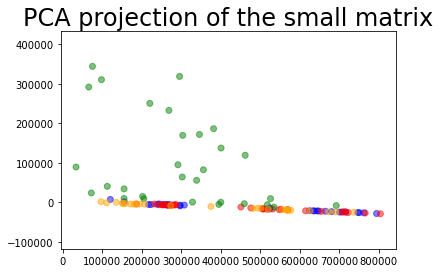

In [63]:
plt.scatter(
    projected[:, 0],
    projected[:, 1],
    alpha=0.5,
    c=cell_types['Sample Characteristic[cell type]'].map(colors)
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('PCA projection of the small matrix', fontsize=24)

### Test with large matrix

In [8]:
large_matrix = mmread('../SingleCell-Files/blood_downloads/E-GEOD-139324.aggregated_filtered_normalised_counts.mtx')
# scaled_large_matrix = StandardScaler().fit_transform(large_matrix.toarray())
# scaled_large_matrix.shape

In [9]:
pca = TruncatedSVD(n_components=2)
projected = pca.fit_transform(large_matrix)
projected.shape

(23206, 2)

Text(0.5, 1.0, 'PCA projection of the large matrix')

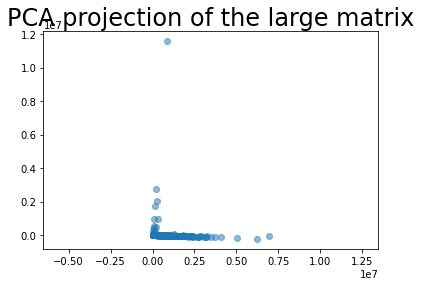

In [11]:
plt.scatter(
    projected[:, 0],
    projected[:, 1],
    alpha=0.5)
plt.gca().set_aspect('equal', 'datalim')
plt.title('PCA projection of the large matrix', fontsize=24)

## Clustering with UMAP

In [65]:
import umap
import matplotlib.pyplot as plt

from scipy.io import mmread
from sklearn.preprocessing import StandardScaler

/home/edusal/.conda/envs/single-cell/lib/python3.8/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


### Test with small matrix

In [4]:
small_matrix = mmread('../SingleCell-Files/blood_downloads/E-MTAB-4850.aggregated_filtered_normalised_counts.mtx')
scaled_small_matrix = StandardScaler().fit_transform(small_matrix.toarray())
scaled_small_matrix.shape

(15912, 63)

In [122]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(small_matrix.transpose())

for cell_type in types:
    cell_type['embedding'] = embedding[cell_type['index']]

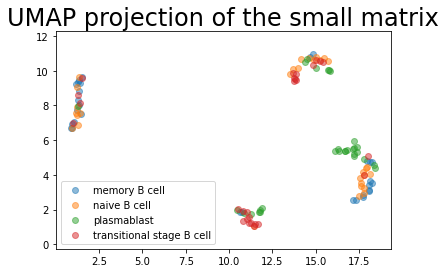

In [123]:
for cell_type in types:

    embedding = cell_type['embedding']
    
    plt.scatter(
        embedding[:, 0],
        embedding[:, 1],
        alpha=0.5,
        label=cell_type['name']
        )
    
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the small matrix', fontsize=24)
plt.legend()
plt.show()

### Test with large matrix

In [7]:
large_matrix = mmread('../SingleCell-Files/blood_downloads/E-GEOD-139324.aggregated_filtered_normalised_counts.mtx')
scaled_large_matrix = StandardScaler().fit_transform(large_matrix.toarray())
scaled_large_matrix.shape

(23206, 164277)

In [14]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(large_matrix)
embedding.shape

(23206, 2)

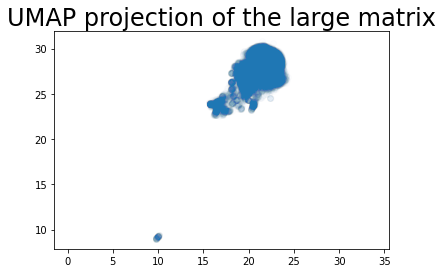

In [16]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    alpha=0.01
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the large matrix', fontsize=24)
plt.show()

## Overlap experiment with UMAP

We get the embeddings for all the projects

In [24]:
for matrix in matrices:
    print(matrix['name'])
    
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(matrix['matrix'])
    print(embedding.shape)
    
    matrix['embedding'] = embedding

E-GEOD-150728
(33334, 2)
E-GEOD-139324
(23206, 2)
E-MTAB-4850
(15912, 2)
E-MTAB-6379
(15920, 2)
E-MTAB-7606
(14162, 2)
E-MTAB-6386
(15545, 2)
E-MTAB-9221
(18958, 2)


Now, we will plot all these embeddings

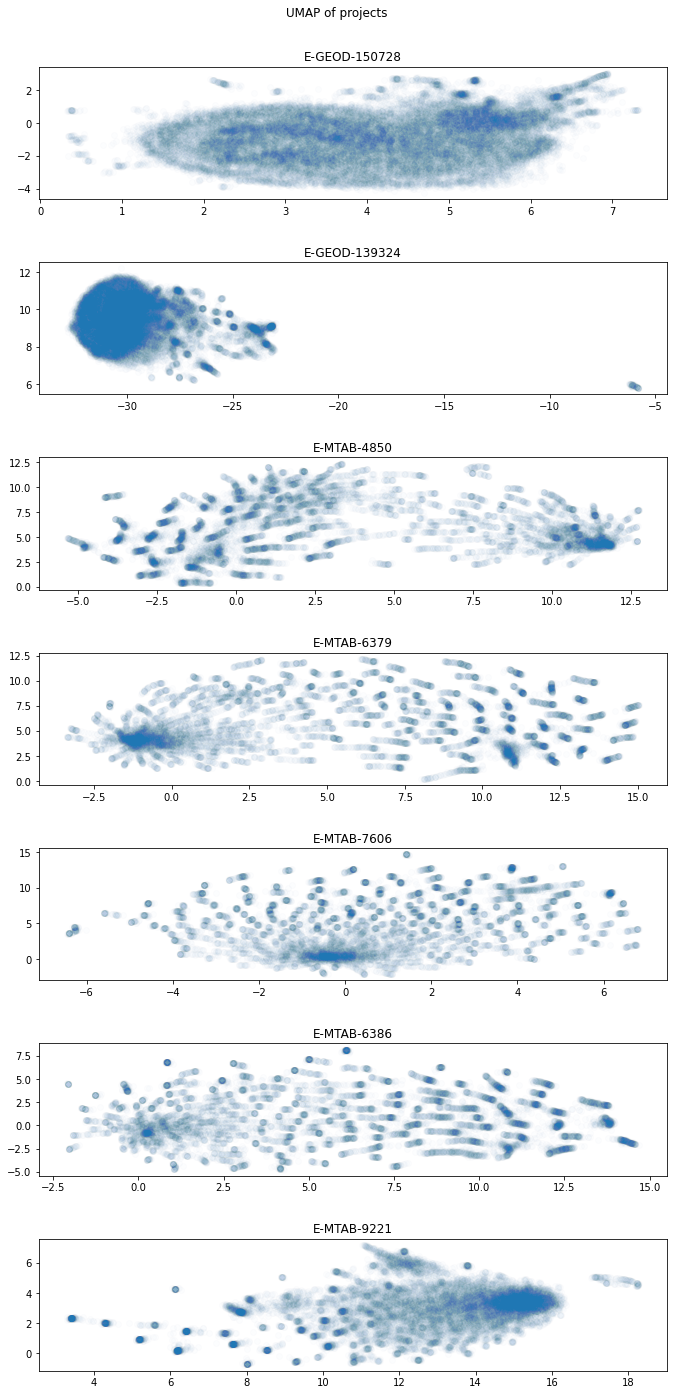

In [39]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(7, figsize=(10,20))
fig.suptitle('UMAP of projects')

for n, matrix in enumerate(matrices):
    embedding = matrix['embedding']
    axs[n].scatter(
        embedding[:, 0],
        embedding[:, 1],
        alpha=0.01
    )
    axs[n].set_title(matrix['name'])

fig.tight_layout(pad=3.0)
fig.show()

The next step is to get the 500 more representive genes in the first component of the UMAP projection.

In [120]:
for matrix in matrices:
    embedding = matrix['embedding']
    
    max_index = (-embedding[:, 0]).argsort()[:500]
    max_values = embedding[max_index, 0]
    
    matrix['max_index'] = max_index
    matrix['max_values'] = max_values

Also, we need the names of these genes

In [214]:
for matrix in matrices:
    genes_names = np.loadtxt(path_to_links + matrix['name'] + '.aggregated_filtered_normalised_counts.mtx_rows', dtype=str)
    matrix['genes_names'] = genes_names[:, 0]
    matrix['max_genes'] = genes_names[matrix['max_index'], 0]

### Calculate overlaps

Now, we will get the overlaps of the matrices by calculating the distance between them. First, we will get the overlap only with the 500 most representative genes, and then comparing the most 500 representative genes of a project with all the genes of another one.

In [382]:
def gene_dif_common(matrix0, matrix1, diff_fun):
    
    common_genes = np.intersect1d(matrix0['max_genes'], matrix1['max_genes'])
    
    if common_genes.size == 0:
        return 0, float('inf')
    
    total_diff = 0
    
    values0 = []
    values1 = []
    
    for gene in common_genes:
        index0 = np.where(matrix0['max_genes'] == gene)
        index1 = np.where(matrix1['max_genes'] == gene)
        
        if index1[0].size == 0:
            continue
            
        value0 = matrix0['max_values'][index0]
        value1 = matrix1['max_values'][index1]
        
        values0.append(value0[0])
        values1.append(value1[0])
        
    total_diff += diff_fun(values0, values1)
        
    return len(common_genes), total_diff

In [407]:
def gene_dif(matrix0, matrix1, diff_fun):
    total_diff = 0
    
    common_genes = 0
    
    values0 = []
    values1 = []
    
    for gene in matrix0['max_genes']:
        index0 = np.where(matrix0['max_genes'] == gene)
        index1 = np.where(matrix1['genes_names'] == gene)

        if index1[0].size == 0:
            continue
        common_genes = common_genes + 1
        
        value0 = matrix0['max_values'][index0]
        value1 = matrix1['embedding'][:, 0][index1]
        
        values0.append(value0[0])
        values1.append(value1[0])
        
    total_diff += diff_fun(values0, values1)
        
    return common_genes, total_diff

In [402]:
def euclidean_dist(values0, values1):
    dist = 0
    for value0, value1 in zip(values0, values1):
        dist += np.linalg.norm(value0-value1)
        
    return dist

In [403]:
def pearson_correlation(values0, values1):
    return np.corrcoef(x=values0, y=values1)[0][1]

In [393]:
def distance_plot(distance_matrix, title="Distance plot"):
    # Calculate the shape of the 2d array
    n = len(matrices)

    # Plot the matrix
    plt.matshow(distance_matrix, cmap="Reds")

    ax = plt.gca()

    # Set the plot labels
    xlabels = [None] + [matrix['name'] for matrix in matrices]
    ylabels = [None] + [matrix['name'] for matrix in matrices]
    ax.set_xticklabels(xlabels, rotation=90)
    ax.set_yticklabels(ylabels)
    plt.title(title)

    plt.show()

#### With euclidean distance:

We can plot the distances. The darker a square, the smaller the distance between the matrices.

<ipython-input-393-65d2ef659926>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=90)
<ipython-input-393-65d2ef659926>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


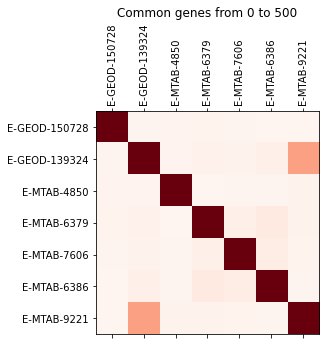

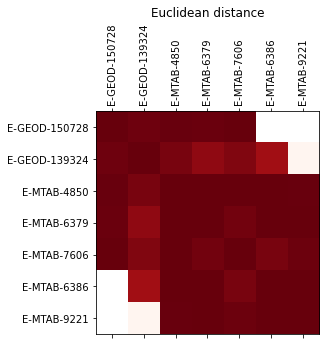

In [396]:
dist_matrix = np.zeros((len(matrices), len(matrices)))
common_matrix = np.zeros((len(matrices), len(matrices)), dtype=int)

for i, matrix0 in enumerate(matrices):
    for j, matrix1 in enumerate(matrices):
        common_genes, dist = gene_dif_common(matrix0, matrix1, euclidean_dist)
        common_matrix[i, j] = common_genes
        dist_matrix[i, j] = dist
distance_plot(common_matrix, title="Common genes from 0 to 500")
distance_plot(-dist_matrix, title="Euclidean distance")

The overlaps with extremly high distance (the ones with white squares) don't have none or few genes in common.

<ipython-input-393-65d2ef659926>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=90)
<ipython-input-393-65d2ef659926>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


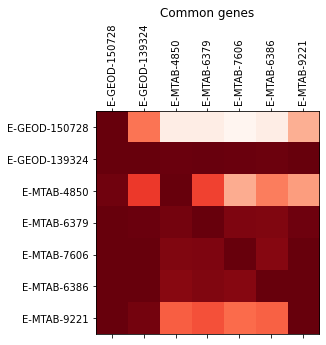

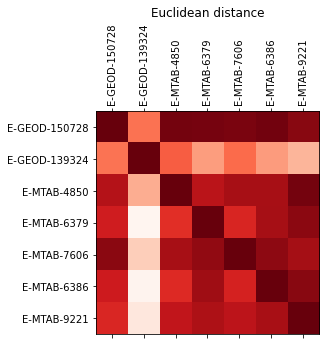

In [409]:
dist_matrix = np.zeros((len(matrices), len(matrices)))
common_matrix = np.zeros((len(matrices), len(matrices)), dtype=int)

for i, matrix0 in enumerate(matrices):
    for j, matrix1 in enumerate(matrices):
        common_genes, dist = gene_dif(matrix0, matrix1, euclidean_dist)
        common_matrix[i, j] = common_genes
        dist_matrix[i, j] = dist
        
distance_plot(common_matrix, title="Common genes")
distance_plot(-dist_matrix, title="Euclidean distance")

#### With correlation

In this case, the darker the square is, the more correlarion between projects.

/home/edusal/.conda/envs/single-cell/lib/python3.8/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/edusal/.conda/envs/single-cell/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/edusal/.conda/envs/single-cell/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
<ipython-input-393-65d2ef659926>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=90)
<ipython-input-393-65d2ef659926>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


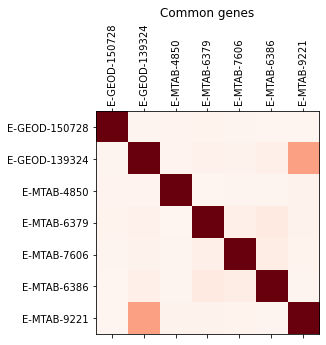

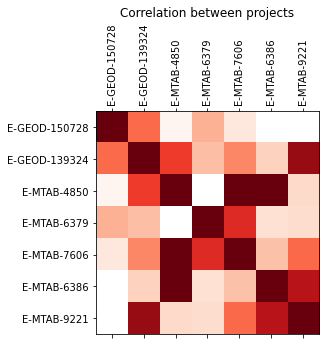

In [410]:
dist_matrix = np.zeros((len(matrices), len(matrices)))
common_matrix = np.zeros((len(matrices), len(matrices)), dtype=int)

for i, matrix0 in enumerate(matrices):
    for j, matrix1 in enumerate(matrices):
        common_genes, dist = gene_dif_common(matrix0, matrix1, pearson_correlation)
        common_matrix[i, j] = common_genes
        dist_matrix[i, j] = dist
        
distance_plot(common_matrix, title="Common genes")
distance_plot(dist_matrix, title="Correlation between projects")

<ipython-input-393-65d2ef659926>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels, rotation=90)
<ipython-input-393-65d2ef659926>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


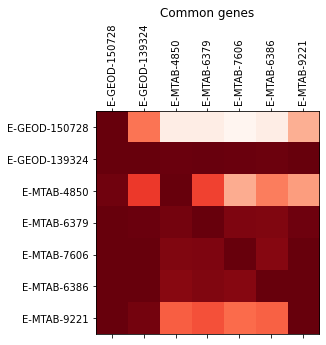

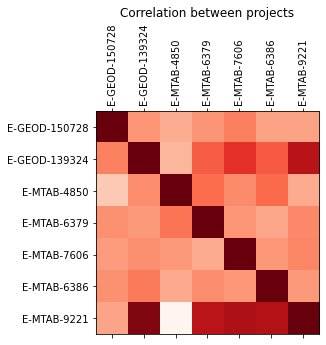

In [411]:
dist_matrix = np.zeros((len(matrices), len(matrices)))
common_matrix = np.zeros((len(matrices), len(matrices)), dtype=int)

for i, matrix0 in enumerate(matrices):
    for j, matrix1 in enumerate(matrices):
        common_genes, dist = gene_dif(matrix0, matrix1, pearson_correlation)
        common_matrix[i, j] = common_genes
        dist_matrix[i, j] = dist
        
distance_plot(common_matrix, title="Common genes")
distance_plot(dist_matrix, title="Correlation between projects")